In [11]:
import numpy as np
import random
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *
import networkx as nx
from utils import *
import time
import csv
import sys
sys.path.insert(1, '../plotting/')
from plotting_functions import *

In [ ]:
coherence_times = [0,1,2]
each_approach_each_x_axis_pont_values = {"Seq":{0:[1,2,3,4,5],1:[3,4,3,4,3,4,3],2:[1,2,5,4,2,3]},
                                         "Par":{0:[2,3,4,6,5],1:[5,5,6,6,3,6,2],2:[6,8,3,9,1,3]},
}
multiple_box_plot_on_each_x_axis("Coherece time (sec)","Optimal cutoffs (sec)",coherence_times,coherence_times,
                                     each_approach_each_x_axis_pont_values,20,19,
                                     20,
                                   20,
                                     20,3,0.6,
                                     30,"../plotting/plots/box_plot_optimal_cutoff.pdf")

In [5]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)


In [6]:
def load_network(topology_file):
    g = nx.Graph()
    print('[*] Loading topology...', topology_file)
    f = open(topology_file, 'r')
    header = f.readline()
    real_nodes = []
    for line in f:
        line = line.strip()
        link = line.split('\t')
        Link_index,s,d,c,dist = link
        dist = float(dist)
        # if rv=="real":
        #     print(link)
        if int(s) not in real_nodes:
            real_nodes.append(int(s))
        if int(d) not in real_nodes:
            real_nodes.append(int(d))
        g.add_edge(int(s),int(d),weight=dist)
        g.add_edge(int(d),int(s),weight=dist)
    f.close()
    return g
def get_user_pairs(G,num_user_pairs,num_of_hups_away,min_distance,max_distance):
    list_of_nodes = []
    each_user_pair_path_links = {}
    each_user_pair_path_length = {}
    covered_pairs = []
    user_pairs = []
    for node in G.nodes:
        list_of_nodes.append(node)
    res = [(a, b) for idx, a in enumerate(list_of_nodes) for b in list_of_nodes[idx + 1:]]
    # random.shuffle(res)
    # res = random.sample(res, len(res))
    n = len(res)
    for i in range(n):
        j = random.randint(0, n-1)
        element = res.pop(j)
        res.append(element)
    for pair in res:
        node1 = pair[0]
        node2 = pair[1]
        e = (node1,node2)
        reverse_e = (node2,node1)
        if (node1!=node2 and e not in G.edges and reverse_e not in G.edges and
            (node1,node2) not in covered_pairs and (node2,node1) not in covered_pairs):
            try:
                shortest_path_length =nx.shortest_path_length(G, source=node1, target=node2, weight="weight")
                path = nx.shortest_path(G, source=node1, target=node2, weight="weight")
                
            except ValueError:
                print(ValueError)
                # dist=-1
                
            if shortest_path_length>=min_distance and shortest_path_length <=max_distance and len(path)>=num_of_hups_away and len(user_pairs)<num_user_pairs:
                node_indx = 0
                path_edges = []
                for node_indx in range(len(path)-1):
                    path_edges.append((path[node_indx],path[node_indx+1]))
                    node_indx+=1
                links = []
                for edge in path_edges:
                    dist =nx.shortest_path_length(G, source=edge[0], target=edge[1], weight="weight")
                    links.append(dist)
                each_user_pair_path_links[(node1,node2)] = links
                each_user_pair_path_length[(node1,node2)] = shortest_path_length
                user_pairs.append((node1,node2))
                covered_pairs.append((node1,node2))
                covered_pairs.append((node2,node1))
    return user_pairs,each_user_pair_path_links,each_user_pair_path_length
def get_user_pairs_path(G,user_pair_list):
    list_of_nodes = []
    each_user_pair_path_links = {}
    covered_pairs = []
    for node in G.nodes:
        list_of_nodes.append(node)
    res = [(a, b) for idx, a in enumerate(list_of_nodes) for b in list_of_nodes[idx + 1:]]
    # from random import shuffle
    # shuffle(res)
    n = len(res)
    for i in range(n):
        j = random.randint(0, n-1)
        element = res.pop(j)
        res.append(element)
    for pair in res:
        node1 = pair[0]
        node2 = pair[1]
        e = (node1,node2)
        reverse_e = (node2,node1)
        if (node1!=node2 and e not in G.edges and reverse_e not in G.edges and
            (node1,node2) not in covered_pairs and (node2,node1) not in covered_pairs):
            try:
                dist =nx.shortest_path_length(G, source=node1, target=node2, weight="weight")
                path = nx.shortest_path(G, source=node1, target=node2, weight="weight")
                
            except ValueError:
                print(ValueError)
                dist=-1
            if (node1,node2) in user_pair_list or (node2,node1) in user_pair_list:
                node_indx = 0
                path_edges = []
                for node_indx in range(len(path)-1):
                    path_edges.append((path[node_indx],path[node_indx+1]))
                    node_indx+=1
                links = []
                for edge in path_edges:
                    dist =nx.shortest_path_length(G, source=edge[0], target=edge[1], weight="weight")
                    links.append(dist)
                each_user_pair_path_links[(node1,node2)] = links
                covered_pairs.append((node1,node2))
                covered_pairs.append((node2,node1))
    return each_user_pair_path_links
def get_optimal_skr(num_τ,user_pair_list,user_pair_indx):
    τ_coh_list = np.logspace(-2,-1,10) # coherence time [sec]
    raw_rate_seq = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    skr_seq = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    Fe2e_seq = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    skr_seq_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    raw_rate_seq_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    Fe2e_seq_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    τ_cut_opt_seq =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    skr_seq_no_cut =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    raw_rate_seq_no_cut = np.zeros((len(user_pair_list),len(τ_coh_list)))

    
    raw_rate_par = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    skr_par = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    Fe2e_par = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    skr_par_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    raw_rate_par_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    Fe2e_par_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    τ_cut_opt_par =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    skr_par_no_cut =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    raw_rate_par_no_cut =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    Fe2e_par_no_cut = np.zeros((len(user_pair_list),len(τ_coh_list)))
    Fe2e_seq_no_cut = np.zeros((len(user_pair_list),len(τ_coh_list)))
    for i_user,user_pair in enumerate(user_pair_list):
        
        Ls = each_user_pair_path_links[(user_pair[0],user_pair[1])]
        Ls = np.array(Ls)
        Le2e = sum(Ls)
        # print(user_pair,len(Ls),Ls,Le2e,end='\r')
        # τ_cut_list = np.logspace(-0.5,2,num_τ)*Ls[0]/c/2 # cutoff [sec]
        τ_cut_list = np.logspace(-1,2,num_τ)*Le2e/c/2 # cutoff [sec]
        # print(raw_rate_seq, skr_seq, Fe2e_seq)
        for i_coh, τ_coh in enumerate(τ_coh_list):
            for i_t, τ_cut in enumerate(τ_cut_list):
                #print("for i_user %s for i_coh %s for i_t %s "%(i_user,i_coh,i_t))
                raw_rate_seq[i_user,i_coh,i_t], skr_seq[i_user,i_coh,i_t], Fe2e_seq[i_user,i_coh,i_t] = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
                raw_rate_par[i_user,i_coh,i_t], skr_par[i_user,i_coh,i_t], Fe2e_par[i_user,i_coh,i_t] = T_parallel_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
                if isnan(skr_seq[i_user,i_coh,i_t]):
                    skr_seq[i_user,i_coh,i_t] = 1e-20
                if isnan(skr_par[i_user,i_coh,i_t]):
                    skr_par[i_user,i_coh,i_t] = 1e-20
                if τ_coh==0.0129155:
                    try:
                        each_user_cutoff_seq_skr[user_pair_indx][τ_cut] = skr_seq[i_user,i_coh,i_t]
                    except:
                        each_user_cutoff_seq_skr[user_pair_indx]={}
                        each_user_cutoff_seq_skr[user_pair_indx][τ_cut] = skr_seq[i_user,i_coh,i_t]

                    try:
                        each_user_cutoff_par_skr[user_pair_indx][τ_cut] = skr_par[i_user,i_coh,i_t]
                    except:
                        each_user_cutoff_par_skr[user_pair_indx]={}
                        each_user_cutoff_par_skr[user_pair_indx][τ_cut] = skr_par[i_user,i_coh,i_t]
            idx_seq = np.argmax(skr_seq[i_user,i_coh,:])
            idx_par = np.argmax(skr_par[i_user,i_coh,:])
    
            skr_seq_opt[i_user,i_coh] = skr_seq[i_user,i_coh,idx_seq]
            raw_rate_seq_opt[i_user,i_coh] = raw_rate_seq[i_user,i_coh,idx_seq]
            Fe2e_seq_opt[i_user,i_coh] = Fe2e_seq[i_user,i_coh,idx_seq]
            τ_cut_opt_seq[i_user,i_coh] = τ_cut_list[idx_seq]
            skr_par_opt[i_user,i_coh] = skr_par[i_user,i_coh,idx_par]
            raw_rate_par_opt[i_user,i_coh] = raw_rate_par[i_user,i_coh,idx_par]
            Fe2e_par_opt[i_user,i_coh] = Fe2e_par[i_user,i_coh,idx_par]
            τ_cut_opt_par[i_user,i_coh] = τ_cut_list[idx_par]
                
            raw_rate_seq_no_cut[i_user,i_coh], skr_seq_no_cut[i_user,i_coh], Fe2e_seq_no_cut[i_user,i_coh] = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)
            raw_rate_par_no_cut[i_user,i_coh], skr_par_no_cut[i_user,i_coh], Fe2e_par_no_cut[i_user,i_coh] = T_parallel_no_cutoff(τ_coh, mu_link, F_link, Ls)
        
        
    return raw_rate_seq_opt,skr_seq_opt,raw_rate_par_opt,skr_par_opt,raw_rate_seq_no_cut,skr_seq_no_cut,raw_rate_par_no_cut,skr_par_no_cut,τ_coh_list,τ_cut_opt_par,τ_cut_opt_seq,Fe2e_seq_opt,Fe2e_par_opt,Fe2e_seq_no_cut,Fe2e_par_no_cut
def get_optimal_skr_with_fixed_cutoff(num_τ,seq_each_coh_optimal_cutoff,par_each_coh_optimal_cutoff,user_pair_list,par_each_user_coh_optimal_cutoff):
    τ_coh_list = np.logspace(-2,-1,10) # coherence time [sec]
    raw_rate_seq = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    skr_seq = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    Fe2e_seq = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    skr_seq_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    raw_rate_seq_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    Fe2e_seq_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    τ_cut_opt_seq =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    skr_seq_no_cut =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    raw_rate_seq_no_cut = np.zeros((len(user_pair_list),len(τ_coh_list)))

    
    raw_rate_par = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    skr_par = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    Fe2e_par = np.zeros((len(user_pair_list),len(τ_coh_list),num_τ))
    skr_par_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    raw_rate_par_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    Fe2e_par_opt = np.zeros((len(user_pair_list),len(τ_coh_list)))
    τ_cut_opt_par =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    skr_par_no_cut =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    raw_rate_par_no_cut =  np.zeros((len(user_pair_list),len(τ_coh_list)))
    Fe2e_par_no_cut = np.zeros((len(user_pair_list),len(τ_coh_list)))
    Fe2e_seq_no_cut = np.zeros((len(user_pair_list),len(τ_coh_list)))
    for i_user,user_pair in enumerate(user_pair_list):
        start_time = time.time()
        Ls = each_user_pair_path_links[(user_pair[0],user_pair[1])]
        Ls = np.array(Ls)
        Le2e = sum(Ls)
        # print(user_pair,len(Ls),Ls,Le2e,end='\r')
        # τ_cut_list = np.logspace(-0.5,2,num_τ)*Ls[0]/c/2 # cutoff [sec]
        
        # print(raw_rate_seq, skr_seq, Fe2e_seq)
        for i_coh, τ_coh in enumerate(τ_coh_list):
            
            seq_optimal_τ_cut = seq_each_coh_optimal_cutoff[i_coh]
            τ_cut_list = [seq_optimal_τ_cut] # cutoff [sec]
            for i_t, τ_cut in enumerate(τ_cut_list):
                #print("for i_user %s for i_coh %s for i_t %s "%(i_user,i_coh,i_t))
                raw_rate_seq[i_user,i_coh,i_t], skr_seq[i_user,i_coh,i_t], Fe2e_seq[i_user,i_coh,i_t] = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
                if isnan(skr_seq[i_user,i_coh,i_t]):
                    print("this is wierd!")
                    skr_seq[i_user,i_coh,i_t] = 1e-20
              
            idx_seq = np.argmax(skr_seq[i_user,i_coh,:])
    
            skr_seq_opt[i_user,i_coh] = skr_seq[i_user,i_coh,idx_seq]
            raw_rate_seq_opt[i_user,i_coh] = raw_rate_seq[i_user,i_coh,idx_seq]
            Fe2e_seq_opt[i_user,i_coh] = Fe2e_seq[i_user,i_coh,idx_seq]
            τ_cut_opt_seq[i_user,i_coh] = τ_cut_list[idx_seq]
                
            raw_rate_seq_no_cut[i_user,i_coh], skr_seq_no_cut[i_user,i_coh], Fe2e_seq_no_cut[i_user,i_coh] = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)
            ending_time = time.time()
            print("took %s done for user pair %s from %s %s from %s coherence values "%(ending_time-start_time,i_user,
                                                                                        len(user_pair_list),
                                                                                        i_coh,len(τ_coh_list)),end="\r")
    counter = 0
    for i_user,user_pair in enumerate(user_pair_list):
        Ls = each_user_pair_path_links[(user_pair[0],user_pair[1])]
        Ls = np.array(Ls)
        Le2e = sum(Ls)
        counter+=1
        # print(user_pair,len(Ls),Ls,Le2e,end='\r')
        # τ_cut_list = np.logspace(-0.5,2,num_τ)*Ls[0]/c/2 # cutoff [sec]
        # print(raw_rate_seq, skr_seq, Fe2e_seq)
        for i_coh, τ_coh in enumerate(τ_coh_list):
            start_time = time.time()
            par_optimal_τ_cut = par_each_coh_optimal_cutoff[i_coh]
            τ_cut_list = [par_optimal_τ_cut] # cutoff [sec]
            for i_t, τ_cut in enumerate(τ_cut_list):
                #print("for i_user %s for i_coh %s for i_t %s "%(i_user,i_coh,i_t))
                
                raw_rate_par[i_user,i_coh,i_t], skr_par[i_user,i_coh,i_t], Fe2e_par[i_user,i_coh,i_t] = T_parallel_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
                # if counter<2:
                #     optimal_cutoff = par_each_user_coh_optimal_cutoff[(user_pair[0],user_pair[1]),i_coh]
                #     raw,skr,f =T_parallel_cutoff(optimal_cutoff,τ_coh, mu_link, F_link, Ls)
                #     print("for user pair %s,%s fixed skr %s optimal cutoff skr %s "%(user_pair[0],user_pair[1],skr_par[i_user,i_coh,i_t],skr),end="\r")
                #     time.sleep(5)
                if isnan(skr_par[i_user,i_coh,i_t]):
                    print("this is wierd")
                    skr_par[i_user,i_coh,i_t] = 1e-20
            idx_par = np.argmax(skr_par[i_user,i_coh,:])
    
            skr_par_opt[i_user,i_coh] = skr_par[i_user,i_coh,idx_par]
            raw_rate_par_opt[i_user,i_coh] = raw_rate_par[i_user,i_coh,idx_par]
            Fe2e_par_opt[i_user,i_coh] = Fe2e_par[i_user,i_coh,idx_par]
            τ_cut_opt_par[i_user,i_coh] = τ_cut_list[idx_par]
                
            raw_rate_par_no_cut[i_user,i_coh], skr_par_no_cut[i_user,i_coh], Fe2e_par_no_cut[i_user,i_coh] = T_parallel_no_cutoff(τ_coh, mu_link, F_link, Ls)
            ending_time = time.time()
            print("took %s done for user pair %s from %s %s from %s coherence values "%(ending_time-start_time,i_user,
                                                                                        len(user_pair_list),
                                                                                        i_coh,len(τ_coh_list)),end="\r")
        
    return raw_rate_seq_opt,skr_seq_opt,raw_rate_par_opt,skr_par_opt,raw_rate_seq_no_cut,skr_seq_no_cut,raw_rate_par_no_cut,skr_par_no_cut,τ_coh_list,τ_cut_opt_par,τ_cut_opt_seq,Fe2e_seq_opt,Fe2e_par_opt,Fe2e_seq_no_cut,Fe2e_par_no_cut
    

In [ ]:
each_user_cutoff_seq_skr = {}
each_user_cutoff_par_skr  ={}

num_user_pairs = 10
num_of_hups_away = 3
min_distance = 50
max_distance = 200
graph = load_network("Surfnet.txt")
all_user_pair_list,each_user_pair_path_links,each_user_pair_path_length = get_user_pairs(graph,num_user_pairs,num_of_hups_away,min_distance,max_distance)
for user_pair,paths in each_user_pair_path_links.items():
    print(user_pair,each_user_pair_path_length[user_pair],len(paths),paths)
user_pair_indx = 0
for user_pair in all_user_pair_list:
    start_time = time.time()
    user_pair_list = [user_pair]
    num_τ = 200
    print(user_pair_indx,num_user_pairs)
    user_pair_list = np.array(user_pair_list)
    raw_rate_seq_opt,skr_seq_opt,raw_rate_par_opt,skr_par_opt,raw_rate_seq_no_cut,skr_seq_no_cut,raw_rate_par_no_cut,skr_par_no_cut,τ_coh_list,τ_cut_opt_par,τ_cut_opt_seq,Fe2e_seq_opt,Fe2e_par_opt,Fe2e_seq_no_cut,Fe2e_par_no_cut= get_optimal_skr(num_τ,user_pair_list,user_pair_indx)
    user_pair_indx+=1

In [ ]:
cutoff_values = set([])
selected_values = []
each_scheme_color = {}
selected_scheme_keys = []
each_user_each_cutoff_skr = {}

for user_i,cutoff_value in each_user_cutoff_seq_skr.items():
    selected_scheme_keys.append(str(user_i)+",seq")
    each_scheme_color[str(user_i)+",seq"] = "C"+str(user_i)
    cutoff_indx = 0
    for c,v in cutoff_value.items():
        # print(user_i,c,v)
        if cutoff_indx%2==0:
            cutoff_values.add(c)
            selected_values.append(v)
            try:
                each_user_each_cutoff_skr[str(user_i)+",seq"][c] = v
            except:
                each_user_each_cutoff_skr[str(user_i)+",seq"] ={}
                each_user_each_cutoff_skr[str(user_i)+",seq"][c] = v
        cutoff_indx+=1

for user_i,cutoff_value in each_user_cutoff_par_skr.items():
    selected_scheme_keys.append(str(user_i)+",par")
    each_scheme_color[str(user_i)+",par"] = "C"+str(user_i)
    cutoff_indx = 0
    for c,v in cutoff_value.items():
        # print(user_i,c,v)
        if cutoff_indx%2==0:
            cutoff_values.add(c)
            selected_values.append(v)
            try:
                each_user_each_cutoff_skr[str(user_i)+",par"][c] = v
            except:
                each_user_each_cutoff_skr[str(user_i)+",par"] ={}
                each_user_each_cutoff_skr[str(user_i)+",par"][c] = v
        cutoff_indx+=1

# for cutoff_value in cutoff_values:
#     par_avg_optimal_cutoff = sum(parallel_optimal_cutoffs)/len(parallel_optimal_cutoffs[])
#     try:
#         each_user_each_cutoff_skr[str(user_i)+",par"][c] = v
#     except:
#         each_user_each_cutoff_skr[str(user_i)+",par"] ={}
#         each_user_each_cutoff_skr[str(user_i)+",par"][c] = v
# print("each_user_cutoff_seq_skr",each_user_cutoff_seq_skr)
cutoff_values = list(cutoff_values)
cutoff_values.sort()
# selected_scheme_keys=[str(0)+",par",str(0)+",seq"]



ploting_simple_y_as_x("Cutoff time (sec)","SKR",
                        18, 18, 14,
                      14, 0, 0,
                      0,0,False,[],max(selected_values)+100,
                      
                      list(selected_scheme_keys),
                      each_user_each_cutoff_skr,
                      cutoff_values,cutoff_values,
                      False,True,False,3,10,
                      "../plotting/plots/line_plot_as_cutoff.pdf",True,2,6.4,3.8,False,each_scheme_color)

In [ ]:
τ_coh_list = np.logspace(-2,-1,10) # coherence time [sec]
print(τ_coh_list)

# uncomment bellow cell if you want to save the data on file. 

In [ ]:
num_user_pairs = 2000
num_of_hups_away = 3
min_distance = 50
max_distance = 350
graph = load_network("Surfnet.txt")
all_user_pair_list,each_user_pair_path_links = get_user_pairs(graph,num_user_pairs,num_of_hups_away,min_distance,max_distance)
user_pair_indx = 0
for user_pair in all_user_pair_list:
    start_time = time.time()
    
    user_pair_list = [user_pair]
    num_τ = 200
    print(len(user_pair_list))
    user_pair_list = np.array(user_pair_list)
    raw_rate_seq_opt,skr_seq_opt,raw_rate_par_opt,skr_par_opt,raw_rate_seq_no_cut,skr_seq_no_cut,raw_rate_par_no_cut,skr_par_no_cut,τ_coh_list,τ_cut_opt_par,τ_cut_opt_seq,Fe2e_seq_opt,Fe2e_par_opt,Fe2e_seq_no_cut,Fe2e_par_no_cut= get_optimal_skr(num_τ,user_pair_list)
    results_file_path = "SURFnet_each_user_coh_protocol_skr_final_version_350km_max_distance.csv"
    # row = Par_ebit,Par_SKR,Seq_ebit,seq_SKR,Par_no_ct_ebit,Par_no_ct_SKR,Seq_no_ct_ebit,Seq_no_ct_SKR
    for i_user,user_pair in enumerate(user_pair_list):
        for i_coh, τ_coh in enumerate(τ_coh_list):
            Par_ebit,Par_SKR,Par_F,Par_opt_ct = raw_rate_par_opt[i_user,i_coh],skr_par_opt[i_user,i_coh],Fe2e_par_opt[i_user,i_coh],τ_cut_opt_par[i_user,i_coh]
            Seq_ebit,seq_SKR,Seq_F,Seq_opt_ct = raw_rate_seq_opt[i_user,i_coh],skr_seq_opt[i_user,i_coh],Fe2e_par_opt[i_user,i_coh],τ_cut_opt_seq[i_user,i_coh]
            Par_no_ct_ebit,Par_no_ct_SKR,Par_no_ct_F= raw_rate_par_no_cut[i_user,i_coh],skr_par_no_cut[i_user,i_coh],Fe2e_par_no_cut[i_user,i_coh]
            Seq_no_ct_ebit,Seq_no_ct_SKR,Seq_no_ct_F = raw_rate_seq_no_cut[i_user,i_coh],skr_seq_no_cut[i_user,i_coh],Fe2e_seq_no_cut[i_user,i_coh]
    
            
            
            with open(results_file_path, 'a') as newFile:                                
                newFileWriter = csv.writer(newFile)
                newFileWriter.writerow([user_pair_indx,user_pair[0],user_pair[1],i_coh, τ_coh,
                                        Par_ebit,Par_SKR,Par_F,Par_opt_ct,
                                        Seq_ebit,seq_SKR,Seq_F,Seq_opt_ct,
                                        Par_no_ct_ebit,Par_no_ct_SKR,Par_no_ct_F,
                                        Seq_no_ct_ebit,Seq_no_ct_SKR,Seq_no_ct_F,num_user_pairs,
                                       num_of_hups_away,min_distance,max_distance])
    user_pair_indx+=1
    ending_time = time.time()
    print("It took %s seconds for user pair %s from %s "%(ending_time-start_time,user_pair_indx,
                                                                                len(all_user_pair_list)
                                                                                ),end="\r")

In [ ]:
import pdb
pdb.set_trace()

In [7]:
results_file="SURFnet_each_user_coh_protocol_skr_finalv2.csv"# for 100 user pairs
results_file = "SURFnet_each_user_coh_protocol_skr_final_version.csv"# for 1000 user pairs and less hop away cases
results_file = "SURFnet_each_user_coh_protocol_skr_final_version_350km_max_distance.csv"# for 2000 user pairs and less hop away cases

index = 0
user_pair_list = set([])
with open(results_file, "r") as f:
    reader = csv.reader( (line.replace('\0','') for line in f) )
    for line in reader:
        # if len(list(user_pair_list))<2:
        user_pair_0=int(line[1])
        user_pair_1=int(line[2])
        user_pair_list.add((user_pair_0,user_pair_1))
        index+=1
user_pair_list = list(user_pair_list)
user_pair_list = user_pair_list[:-1]
num_user_pairs = 400#len(user_pair_list)
print(len(user_pair_list))


num_τ = 200
τ_coh_list = np.logspace(-2,-1,10) # coherence time [sec]
raw_rate_seq = np.zeros((num_user_pairs,len(τ_coh_list),num_τ))
skr_seq = np.zeros((num_user_pairs,len(τ_coh_list),num_τ))
Fe2e_seq = np.zeros((num_user_pairs,len(τ_coh_list),num_τ))
skr_seq_opt = np.zeros((num_user_pairs,len(τ_coh_list)))
raw_rate_seq_opt = np.zeros((num_user_pairs,len(τ_coh_list)))
Fe2e_seq_opt = np.zeros((num_user_pairs,len(τ_coh_list)))
τ_cut_opt_seq =  np.zeros((num_user_pairs,len(τ_coh_list)))
skr_seq_no_cut =  np.zeros((num_user_pairs,len(τ_coh_list)))
raw_rate_seq_no_cut = np.zeros((num_user_pairs,len(τ_coh_list)))


raw_rate_par = np.zeros((num_user_pairs,len(τ_coh_list),num_τ))
skr_par = np.zeros((num_user_pairs,len(τ_coh_list),num_τ))
Fe2e_par = np.zeros((num_user_pairs,len(τ_coh_list),num_τ))
skr_par_opt = np.zeros((num_user_pairs,len(τ_coh_list)))
raw_rate_par_opt = np.zeros((num_user_pairs,len(τ_coh_list)))
Fe2e_par_opt = np.zeros((num_user_pairs,len(τ_coh_list)))
τ_cut_opt_par =  np.zeros((num_user_pairs,len(τ_coh_list)))
skr_par_no_cut =  np.zeros((num_user_pairs,len(τ_coh_list)))
raw_rate_par_no_cut =  np.zeros((num_user_pairs,len(τ_coh_list)))

par_each_coh_optimal_cutoffs = {}
seq_each_coh_optimal_cutoffs = {}
par_each_user_coh_optimal_cutoff={}
seq_each_user_coh_optimal_cutoff = {}

index = 0
results_file="SURFnet_each_user_coh_protocol_skr_finalv2.csv"# for 100 user pairs
results_file = "SURFnet_each_user_coh_protocol_skr_final_version.csv"# for 1000 user pairs and less hop away cases
results_file = "SURFnet_each_user_coh_protocol_skr_final_version_350km_max_distance.csv"# for 2000 user pairs and less hop away cases
covered_user_pairs = set([])
with open(results_file, "r") as f:
    reader = csv.reader( (line.replace('\0','') for line in f) )
    for line in reader:
        user_i = int(line[0])
        user_pair_0=int(line[1])
        user_pair_1=int(line[2])
        if user_i <num_user_pairs:
            coh_i=int(line[3])
            τ_coh=float(line[4])
            Par_ebit=float(line[5])
            Par_SKR=float(line[6])
            Par_F=float(line[7])
            Par_opt_ct = float(line[8])
            Seq_ebit=float(line[9])
            seq_SKR=float(line[10])
            seq_F=float(line[11])
            Seq_opt_ct = float(line[12])
            Par_no_ct_ebit=float(line[13])
            Par_no_ct_SKR=float(line[14])
            Par_no_ct_F=float(line[15])
            Seq_no_ct_ebit=float(line[16])
            Seq_no_ct_SKR=float(line[17])
            Seq_no_ct_F = float(line[18])
            # print(user_i,coh_i)
            skr_seq_opt[user_i,coh_i] =seq_SKR
            raw_rate_seq_opt[user_i,coh_i] =Seq_ebit
            skr_seq_no_cut[user_i,coh_i] =Seq_no_ct_SKR
            raw_rate_seq_no_cut[user_i,coh_i] =Seq_no_ct_ebit
            skr_par_opt[user_i,coh_i] =Par_SKR
            raw_rate_par_opt[user_i,coh_i] =Par_ebit
            skr_par_no_cut[user_i,coh_i] =Par_no_ct_SKR
            raw_rate_par_no_cut[user_i,coh_i] =Par_no_ct_ebit
            try:
                par_each_coh_optimal_cutoffs[coh_i].append(Par_opt_ct)
            except:
                par_each_coh_optimal_cutoffs[coh_i] = [Par_opt_ct]
            try:
                seq_each_coh_optimal_cutoffs[coh_i].append(Seq_opt_ct)
            except:
                seq_each_coh_optimal_cutoffs[coh_i] = [Seq_opt_ct]

            par_each_user_coh_optimal_cutoff[(user_pair_0,user_pair_1),coh_i] = Par_opt_ct
            seq_each_user_coh_optimal_cutoff[(user_pair_0,user_pair_1),coh_i] = Seq_opt_ct
            covered_user_pairs.add((user_pair_0,user_pair_1))
        index+=1

1088


In [8]:
seq_each_coh_optimal_cutoff={}
par_each_coh_optimal_cutoff = {}

for cor_i,values in par_each_coh_optimal_cutoffs.items():
    avg_cutoff = sum(values)/len(values)
    par_each_coh_optimal_cutoff[cor_i] = avg_cutoff
for cor_i,values in seq_each_coh_optimal_cutoffs.items():
    avg_cutoff = sum(values)/len(values)
    seq_each_coh_optimal_cutoff[cor_i] = avg_cutoff

user_pair_list = list(user_pair_list)
print(len(user_pair_list))
num_τ = 1
graph = load_network("Surfnet.txt")
each_user_pair_path_links = get_user_pairs_path(graph,user_pair_list)
print(len(user_pair_list))
user_pair_list = np.array(user_pair_list)

# for user_pair_coh_id,opt in par_each_user_coh_optimal_cutoff.items():
#     print(user_pair_coh_id[0],user_pair_coh_id[1],opt,par_each_coh_optimal_cutoff[user_pair_coh_id[1]])

τ_coh_list = np.logspace(-2,-1,10) # coherence time [sec]

raw_rate_seq_fixed_cut,skr_seq_fixed_cut,raw_rate_par_fixed_cut,skr_par_fixed_cut,raw_rate_seq_no_cut,skr_seq_no_cut,raw_rate_par_no_cut,skr_par_no_cut,τ_coh_list,τ_cut_opt_par,τ_cut_opt_seq,Fe2e_seq_opt,Fe2e_par_opt,Fe2e_seq_no_cut,Fe2e_par_no_cut= get_optimal_skr_with_fixed_cutoff(num_τ,
                                                                                                                                                                                                                                                                                            seq_each_coh_optimal_cutoff,
                                                                                                                                                                                                                                                                                            par_each_coh_optimal_cutoff,
                                                                                                                                                                                                                                                                                            user_pair_list,
                                                                                                                                                                                                                                                                                            par_each_user_coh_optimal_cutoff)




1088
[*] Loading topology... Surfnet.txt
1088


handles, labels [<matplotlib.lines.Line2D object at 0x7fd9ddae6a70>, <matplotlib.lines.Line2D object at 0x7fd9dd307490>, <matplotlib.lines.Line2D object at 0x7fd9dd3054e0>, <matplotlib.lines.Line2D object at 0x7fd9dd307010>] ['Seq', 'Seq2', 'Par', 'Par2']


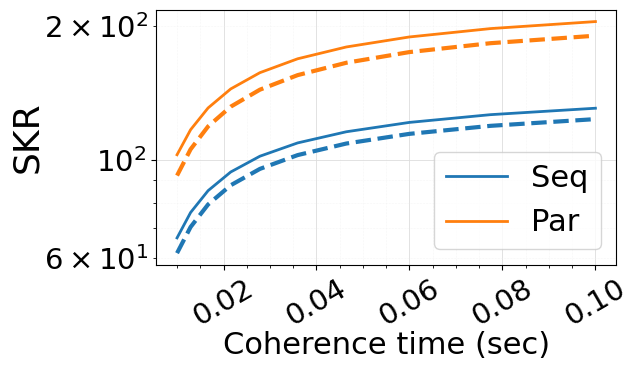

In [25]:
def set_plot_parameters():
    font_size = 44
    image_width = 6.5
    image_lenght = 3.8
    legend_flag  =True
    legends_on_the_right_flag = True
    legend_font_size = 18
    fig = plt.figure()
    
        
    fig.set_size_inches(image_width, image_lenght, forward=True) 
    
    label_size = 40
    csfont = {'fontname':'Times New Roman'}
    plt.rcParams['xtick.labelsize'] = 21 
    plt.rcParams['ytick.labelsize']= 21
    plt.xlabel("Repeater position", fontsize=24,labelpad=0)
    plt.ylabel("Rate",fontsize=22,labelpad=0)
    plt.grid(True)
    plt.tight_layout()
    
   
  
    ax = plt.subplot(111)
    # plt.grid(which='minor', linestyle=':', linewidth='0.1', color='black')
    # plt.minorticks_on()
    plt.tight_layout()
    return plt

plt = set_plot_parameters()
color_indx = -1
# plt.figure(figsize=(4,4))
color_indx+=1
plt.plot(τ_coh_list,np.mean(skr_seq_opt, axis= 0),"-",linewidth=2.0,color=f"C{color_indx}",label = "Seq")
# color_indx+=1
plt.plot(τ_coh_list,np.mean(skr_seq_fixed_cut, axis= 0),linestyle='dashed',linewidth=3.0,color=f"C{color_indx}",label = "Seq2")
# color_indx+=1
# plt.plot(τ_coh_list,np.mean(skr_seq_no_cut, axis= 0),linestyle='dotted',linewidth=4.0,color=f"C{color_indx}")
color_indx+=1
plt.plot(τ_coh_list,np.mean(skr_par_opt, axis= 0),"-",linewidth=2.0,color=f"C{color_indx}",label = "Par")
# color_indx+=1
plt.plot(τ_coh_list,np.mean(skr_par_fixed_cut, axis= 0),linestyle='dashed',linewidth=3.0,color=f"C{color_indx}",label = "Par2")
# color_indx+=1
# plt.plot(τ_coh_list,np.mean(skr_par_no_cut, axis= 0),linestyle='dotted',linewidth=4.0,color=f"C{color_indx}")
legend_labels = ["Seq, optimal cutoff","Seq, fixed cutoff","Seq, w.o. cutoff",
                "Par, optimal cutoff","Par, fixed cutoff","Par, w.o. cutoff"
                ]
legend_labels = ["Seq, optimal cutoff","Seq, fixed cutoff",
                "Par, optimal cutoff","Par, fixed cutoff",
                ]
legend_labels = ["Seq",
                "Par"
                ]
plt.legend([label for label in legend_labels ],handlelength=1.0,fontsize=22, ncol=2,handleheight=2.4, labelspacing=0.02)
ax = plt.subplot(111)
# ax.legend([label for label in legend_labels ],handlelength=1.0,fontsize=22,loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend([label for label in legend_labels ],handlelength=1.0,ncol=2,fontsize=22,loc='center left', bbox_to_anchor=(0.0, 1.21))
handles, labels = ax.get_legend_handles_labels()
display = (0,2)
print("handles, labels",handles, labels)
ax.legend([handle for i,handle in enumerate(handles) if i in display],
      [label for i,label in enumerate(labels) if i in display], loc = 'best',fontsize=22)
# bbox_to_anchor= (0.0, 1.01)
plt.yscale('log')
# plt.legend()
plt.xlabel("Coherence time (sec)", fontsize=22,labelpad=0)
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize']= 20
#matplotlib.rcParams['text.usetex'] = True
# fig = plt.figure()
# plt.set_size_inches(6.4, 3.8, forward=True)# default 
plt.tight_layout()
plt.ylabel("SKR",fontsize=26,labelpad=0)
plt.xticks(rotation = 30)
plt.grid(True)
ax.grid(which='major', color='#DDDDDD', linewidth=0.6)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.4)
# Make the minor ticks and gridlines show.
ax.minorticks_on()
plt.tight_layout()
plt.savefig("../plotting/plots/figure5.pdf")

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1]


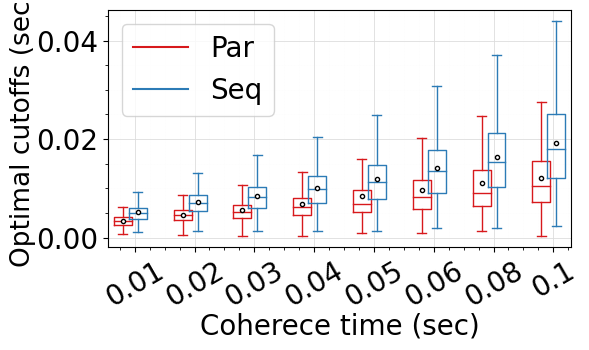

In [15]:

coherence_times  =set([])
each_approach_each_x_axis_pont_values  ={}
each_scheme_coherence_optimal_cutoff_values = {}
each_scheme_coherence_avg_optimal_cutoff_value = {}
selected_values = []

for coherence_index,cutof_values in par_each_coh_optimal_cutoffs.items():
    coh_t = τ_coh_list[coherence_index]
    # print(user_pair_coherence_index,cutof_value,user_pair_coherence_index[1])
    coh_t = round(coh_t,2)
    try:
        each_approach_each_x_axis_pont_values["Par"][coh_t]=cutof_values
    except:
        each_approach_each_x_axis_pont_values["Par"]={}
        each_approach_each_x_axis_pont_values["Par"][coh_t]=cutof_values


    # try:
    #     each_scheme_coherence_optimal_cutoff_values["Par"][coh_t].append(cutof_value)
    # except:
    #     try:
    #         each_scheme_coherence_optimal_cutoff_values["Par"][coh_t]=[cutof_value]
    #     except:
    #         each_scheme_coherence_optimal_cutoff_values["Par"]={}
    #         each_scheme_coherence_optimal_cutoff_values["Par"][coh_t]=[cutof_value]
    coherence_times.add(coh_t)

for coherence_index,cutof_values in seq_each_coh_optimal_cutoffs.items():
    coh_t = τ_coh_list[coherence_index]
    coh_t = round(coh_t,2)
    try:
        each_approach_each_x_axis_pont_values["Seq"][coh_t] = cutof_values
    except:
        each_approach_each_x_axis_pont_values["Seq"]={}
        each_approach_each_x_axis_pont_values["Seq"][coh_t]=cutof_values


    # try:
    #     each_scheme_coherence_optimal_cutoff_values["Seq"][coh_t].append(cutof_value)
    # except:
    #     try:
    #         each_scheme_coherence_optimal_cutoff_values["Seq"][coh_t]=[cutof_value]
    #     except:
    #         each_scheme_coherence_optimal_cutoff_values["Seq"]= {}
    #         each_scheme_coherence_optimal_cutoff_values["Seq"][coh_t]=[cutof_value]
            

    coherence_times.add(coh_t)

coherence_times = list(coherence_times)
coherence_times.sort()
multiple_box_plot_on_each_x_axis("Coherece time (sec)","Optimal cutoffs (sec)",coherence_times,coherence_times,
                                     each_approach_each_x_axis_pont_values,20,19,
                                     20,
                                   20,
                                     20,3,0.6,
                                     30,"../plotting/plots/box_plot_optimal_cutoff.pdf")


print(coherence_times)

In [ ]:
selected_values = []
each_scheme_color = {}
selected_scheme_keys = set(["Seq, avg. optimal","Par, avg. optimal"])
each_scheme_coherence_avg_optimal_cutoff_value = {}
for coherence_index,cutof_values in seq_each_coh_optimal_cutoffs.items():
    coherence = τ_coh_list[coherence_index]
    avg_cutoff = sum(cutof_values)/len(cutof_values)
    try:
        each_scheme_coherence_avg_optimal_cutoff_value["Seq, avg. optimal"][coherence] = avg_cutoff
    except:
        each_scheme_coherence_avg_optimal_cutoff_value["Seq, avg. optimal"]={}
        each_scheme_coherence_avg_optimal_cutoff_value["Seq, avg. optimal"][coherence]=avg_cutoff
    each_scheme_color["Seq, avg. optimal"] = "red"
    for user_i,cutoff in enumerate(cutof_values):
        if user_i<10:
            try:
                each_scheme_coherence_avg_optimal_cutoff_value["Seq, optimal"+str(user_i)][coherence] = cutoff
            except:
                each_scheme_coherence_avg_optimal_cutoff_value["Seq, optimal"+str(user_i)]={}
                each_scheme_coherence_avg_optimal_cutoff_value["Seq, optimal"+str(user_i)][coherence]=cutoff
            selected_scheme_keys.add("Seq, optimal"+str(user_i))
            each_scheme_color["Seq, optimal"+str(user_i)] = "blue"
            selected_values.append(cutoff)
    selected_values.append(avg_cutoff)
for coherence_index,cutof_values in par_each_coh_optimal_cutoffs.items():
    coherence = τ_coh_list[coherence_index]
    avg_cutoff = sum(cutof_values)/len(cutof_values)
    try:
        each_scheme_coherence_avg_optimal_cutoff_value["Par, avg. optimal"][coherence] = avg_cutoff
    except:
        each_scheme_coherence_avg_optimal_cutoff_value["Par, avg. optimal"]={}
        each_scheme_coherence_avg_optimal_cutoff_value["Par, avg. optimal"][coherence]=avg_cutoff
    each_scheme_color["Par, avg. optimal"] = "black"
    for user_i,cutoff in enumerate(cutof_values):
        if user_i<10:
            try:
                each_scheme_coherence_avg_optimal_cutoff_value["Par, optimal"+str(user_i)][coherence] = cutoff
            except:
                each_scheme_coherence_avg_optimal_cutoff_value["Par, optimal"+str(user_i)]={}
                each_scheme_coherence_avg_optimal_cutoff_value["Par, optimal"+str(user_i)][coherence]=cutoff
            each_scheme_color["Par, optimal"+str(user_i)] = "green"
            selected_scheme_keys.add("Par, optimal"+str(user_i))
            selected_values.append(cutoff)
    selected_values.append(avg_cutoff)
selected_scheme_keys = list(selected_scheme_keys)
print(len(selected_scheme_keys))

ploting_simple_y_as_x("Coherence time (sec)","Avg of optimal \n cutoffs (sec)",
                        18, 18, 14,
                      14, 0, 0,
                      0,0,False,[],max(selected_values),
                      
                      list(selected_scheme_keys),
                      each_scheme_coherence_avg_optimal_cutoff_value,
                      coherence_times,coherence_times,
                      False,True,True,10,4,
                      "../plotting/plots/line_plot_optimal_cutoff.pdf",True,2,6.4,3.8,False,each_scheme_color)